## Forecasts for Product Demand
### Background
- https://www.kaggle.com/datasets/felixzhao/productdemandforecasting?resource=download
- The dataset contains historical product demand for a manufacturing company with footprints globally. 
- The company provides thousands of products within dozens of product categories. 
- There are four central warehouses to ship products within the region it is responsible for. 
- Since the products are manufactured in different locations all over the world, it normally takes more than one month to ship products via ocean to different central warehouses. 
- If forecasts for each product in different central with reasonable accuracy for the **monthly demand for month after next** can be achieved, it would be beneficial to the company in multiple ways.

## Problem Definition

- Perform EDA
- Build a machine learning model predicting order counts for the next month by the warehouse
- Evaluate the performance of the model

In [1]:
import logging
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import shap
#import check_numeric

sns.set_style('darkgrid')
sns.set_palette("bright")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
file_name = "data/Historical Product Demand.csv"        
start_date = '2012-01-01'
end_date = '2016-12-31'

## Class Info.

In [12]:
## todo: evaluation
## todo: 딥러닝, 앙상블 등
## todo: SQL

In [28]:
class OrderPredictByCenter():

    """
    하루씩 stride, 최신 데이터를 계속 학습하면서 다음날 주문수에 대해 예측수행하는 클래스
    1) 추출 및 전처리
    2) 피처 엔지니어링: 샘플 데이터이므로 실무상황 대비 풍부하지 못함
    3) 학습 및 예측수행
    """
    
    def __init__(self):

        self.file_path = "data/Historical Product Demand.csv"
        self.start_date = '2012-01-01'
        self.end_date = '2016-12-31'
        self.shap_cut_date = '2016-12-01'
        self.label_encoder = LabelEncoder()
        self.target_encoder = ce.TargetEncoder(cols=['warehouse'])        
        self.base_model = LGBMRegressor()
        self.check_shap_value = False # shap 확인 필요시
        self.opt_param = False # True 경우 파라메터 최적화 진행
        self.param_space = {
                            'learning_rate': np.logspace(-3, 0, num=100),
                            'n_estimators': np.arange(50, 300, step=10),
                            'max_depth': np.arange(3, 11),
                            'num_leaves': np.arange(10, 101),
                            'min_child_samples': np.arange(5, 31)
                            } 
                
    @staticmethod
    def _check_if_numeric(value):
        """
        값이 만약 수치형이면 True, 아니면 에러대신 False 반환
        """
        try:
            pd.to_numeric(value)
            return True
        except (TypeError, ValueError):
            return False


    def load_data(self):

        """
        데이터 불러와서 타깃의 값이 수치형 아닌 경우 제거
        """
        df = pd.read_csv(self.file_path) # local path
        df.columns = ['prd_code', 'warehouse', 'category', 'date', 'order']

        # 수치형이 아닌 경우 제거
        df['is_num'] = df.order.apply(self._check_if_numeric)
        df = df.query("is_num == True").drop('is_num', axis=1)

        # datetime, int 형태로 컬럼 타입을 변환
        df['date'] = pd.to_datetime(df['date'])
        df.rename(columns={'date':'target_date'}, inplace=True)        
        df['order'] = df['order'].astype(int)    
        
        # 비정상 데이터 제거
        df = df.query("target_date >= @self.start_date and target_date <= @self.end_date")
        
        # 센터별로 집계
        df = df.groupby(["warehouse", "target_date"])['order'].sum().reset_index()                
        return df 
    
    
    def add_date_features(self, df):
        
        """
        날짜 관련 피처엔지니어링
        """
        df['month'] = df['target_date'].dt.month
        df['day'] = df['target_date'].dt.dayofweek
        df['dayofweek'] = df['target_date'].dt.day_name()
        df["weekend_yn"] = np.where(df["dayofweek"].isin(["Saturday", "Sunday"]), 1, 0)  # 주말여부
        df["dayofyear"] = df['target_date'].dt.dayofyear  # 연간 일                
        df["week_no"] = df['target_date'].dt.isocalendar()['week'].astype('int')
        df['week_num'] = np.ceil((df['target_date'].dt.to_period('M').dt.to_timestamp().dt.weekday + df['target_date'].dt.day) / 7.0).astype(int)  # 월별주차
        df = pd.concat([df, pd.get_dummies(data=df['dayofweek'], prefix='dayofweek')], axis=1)  # 요일 one-hot encoding

        # 월별 누적주문수
        # monthly prediction을 위해 YYYY-MM 형태로 변환
        df['date_month'] = pd.to_datetime(df['target_date'].dt.strftime('%Y-%m'))        
        df['ord_cnt_cum'] = df.groupby(['date_month', 'warehouse'])['order'].cumsum()        
        return df
    
    
    def add_fe_laggging(self, df, max_lagging_n=8):

        """
        lagging 피처 및 rolling mean 피처 추가
        """
        # 이전 동요일 주문수 피처
        for n in np.arange(1, max_lagging_n):
            df[f'ord_cnt_w{n}'] = df.groupby(['warehouse', 'dayofweek'])['order'].shift(n)
            
        for n in np.arange(1, 8):
            df[f'ord_cnt_cum_w{n}'] = df.groupby(['warehouse', 'dayofweek'])['ord_cnt_cum'].shift(n)            
            # df[f'ord_cnt_roll_w{n}'] = df.groupby(['warehouse', 'dayofweek'])['ord_cnt_w4'].transform(lambda x: x.rolling(n,1).mean())
            # df[f'ord_cnt_ewm_w{n}'] = df.groupby(['warehouse', 'dayofweek'])['ord_cnt_w4'].transform(lambda x: x.ewm(span=n, adjust=False).mean())

        return df         
      
    
    def add_fe_change_ratio(self, df, max_change_n=8):
        
        """
        주차별 변동율을 피처로 활용
        """
        df[f'ord_cnt_change_w1'] = (df[f'ord_cnt_w1']-df[f'ord_cnt_w2'])/df[f'ord_cnt_w2']
        df[f'ord_cnt_change_w2'] = (df[f'ord_cnt_w2']-df[f'ord_cnt_w3'])/df[f'ord_cnt_w3']
        df[f'ord_cnt_change_w4'] = (df[f'ord_cnt_w4']-df[f'ord_cnt_w5'])/df[f'ord_cnt_w5']
        df[f'ord_cnt_change_w6'] = (df[f'ord_cnt_w6']-df[f'ord_cnt_w7'])/df[f'ord_cnt_w7']

        df[f'ord_cnt_change_w1'] = (df[f'ord_cnt_cum_w1']-df[f'ord_cnt_cum_w2'])/df[f'ord_cnt_cum_w2']
        df[f'ord_cnt_change_w2'] = (df[f'ord_cnt_cum_w2']-df[f'ord_cnt_cum_w3'])/df[f'ord_cnt_cum_w3']
        df[f'ord_cnt_change_w4'] = (df[f'ord_cnt_cum_w4']-df[f'ord_cnt_cum_w5'])/df[f'ord_cnt_cum_w5']
        df[f'ord_cnt_change_w6'] = (df[f'ord_cnt_cum_w6']-df[f'ord_cnt_cum_w7'])/df[f'ord_cnt_cum_w6']
        
        return df
     
    
    def add_fe_ord_ratio(self, df, max_lagging_n=8):
        """
        센터별 월별 일별 비중을 lagging
        """
        df['ord_sum_cnt'] = df.groupby(['warehouse','date_month'])['order'].transform(sum) # todo: delete
        df['ord_ratio_day'] = df['order']/df['ord_cnt_cum'] # todo: delete
        
        for n in np.arange(1, max_lagging_n):
            df[f'ord_ratio_w{n}'] = df.groupby(['warehouse', 'dayofweek'])['ord_ratio_day'].shift(n)
        
        return df
     
        
    def fit_predict(self, df):
        
        """
        특정일 기준으로 데이터셋 구분후 인코딩
        """
        # index 지정
        if 'target_date' in df.columns:
            df = df.set_index("target_date")         
        
        # 컬럼제거: 에러 및 leakage 방지
        drop_cols = ['dayofweek','date_month','ord_cnt_cum', 'ord_sum_cnt', 'ord_ratio_day']
        df = df.drop(drop_cols, axis=1)        
        
        pred_res = pd.DataFrame()
        warehouse_list = df['warehouse'].unique()
        for wh in warehouse_list:
            for date in pd.period_range('2016-12-01', '2016-12-30'):
                subset = df.query("warehouse == @wh")
                try:
                    train = subset[subset.index < str(date)][:-1] # 예측당일값 학습에서 제거 
                    pred = subset[subset.index == str(date)]

                    train['warehouse_label_enc'] = self.label_encoder.fit_transform(train['warehouse'])
                    train['warehouse_target_enc'] = self.target_encoder.fit_transform(train['warehouse'], train['order'])
                    train = train.drop("warehouse", axis=1)
                    X_train = train.drop("order", axis=1)
                    y_train = train[['order']]

                    # 성능 체크 용도
                    pred['warehouse_label_enc'] = self.label_encoder.transform(pred['warehouse'])
                    pred['warehouse_target_enc'] = self.target_encoder.transform(pred['warehouse'], pred['order'])

                    X_pred = pred.drop(["order", "warehouse"], axis=1)
                    y_pred = pred[['warehouse','order']]        
                    
                    if self.opt_param == False:
                        # base model
                        model = self.base_model
                        model.fit(X_train, y_train)
                        y_pred['pred_cnt'] = model.predict(X_pred).astype(int)
                        pred_res = pred_res.append(y_pred)                     
                    else:
                        random_search = RandomizedSearchCV(
                                                estimator=self.base_model,
                                                param_distributions=self.param_space,
                                                n_iter=50,
                                                scoring='neg_mean_squared_error',  
                                                cv=3,  
                                                verbose=1,
                                                n_jobs=-1,  
                                                random_state=42
                                            )
                        random_search.fit(X_train, y_train)
                        #print("Best hyperparameters:", random_search.best_params_)
                        #print("Best negative mean squared error:", random_search.best_score_)                        
                        y_pred['pred_cnt'] = random_search.predict(X_pred).astype(int)
                        pred_res = pred_res.append(y_pred)                                             
                except:
                    pass        
        
        # 예측결과 df
        pred_res = pred_res.query("order >= 1000 and pred_cnt > 0")
        pred_res['ape'] = 1-(abs(pred_res['pred_cnt'] - pred_res['order'])/pred_res['order'])
        print(pred_res.groupby("warehouse").ape.median())
        return df, pred_res
    
    
    def add_fe_xxx(df, self):
        """
        Kaggle 샘플 데이터이므로 다양한 피처 활용이 불가.
        잠재적 활용 가능 피처는 아래와 같음.
        """
        # 날씨, 기온, 강수량 등
        # 지역, 인구, 소득, 밀집도 및 경제 등 거시적
        # 프로모션 및 마케팅 정보
        # 산업, 비즈니스, 도메인, 구조적 특성
        # 로그 및 트래픽 데이터
        pass
        
    
    
    def check_feature_importance(df, self):        
        """
        shap value 확인
        """        
        # shap value check
        train = df[df.index < self.shap_cut_date]
        pred = df[df.index >= self.shap_cut_date]

        train['warehouse_label_enc'] = self.label_encoder.fit_transform(train['warehouse'])
        train['warehouse_target_enc'] = self.target_encoder.fit_transform(train['warehouse'], train['order'])
        train = train.drop("warehouse", axis=1)
        X_train = train.drop("order", axis=1)
        y_train = train[['order']]

        # 성능 체크 용도
        pred['warehouse_label_enc'] = self.label_encoder.transform(pred['warehouse'])
        pred['warehouse_target_enc'] = self.target_encoder.transform(pred['warehouse'], pred['order'])
        X_pred = pred.drop(["order", "warehouse"], axis=1)
        y_pred = pred[['warehouse','order']]        

        model = self.base_model
        model.fit(X_train, y_train)
        y_pred['pred_cnt'] = model.predict(X_pred).astype(int)

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_pred)        
        shap.summary_plot(shap_values, X_pred)        

        
    def process(self):        
        """
        전처리 및 FE, Modeling, Feature Impoartance
        """
        
        df = self.load_data()
        df = self.add_date_features(df)
        df = self.add_fe_laggging(df)
        df = self.add_fe_change_ratio(df)
        df = self.add_fe_ord_ratio(df)
        df, pred_res = self.fit_predict(df)        
        # if self.check_shap_value == True:
        #     self.check_feature_importance(df)
    
        return df, pred_res

self = OrderPredictByCenter()    

In [29]:
df, pred_res = self.process()

warehouse
Whse_A    0.699932
Whse_C    0.310419
Whse_J    0.807897
Whse_S    0.172161
Name: ape, dtype: float64


<Axes: xlabel='target_date'>

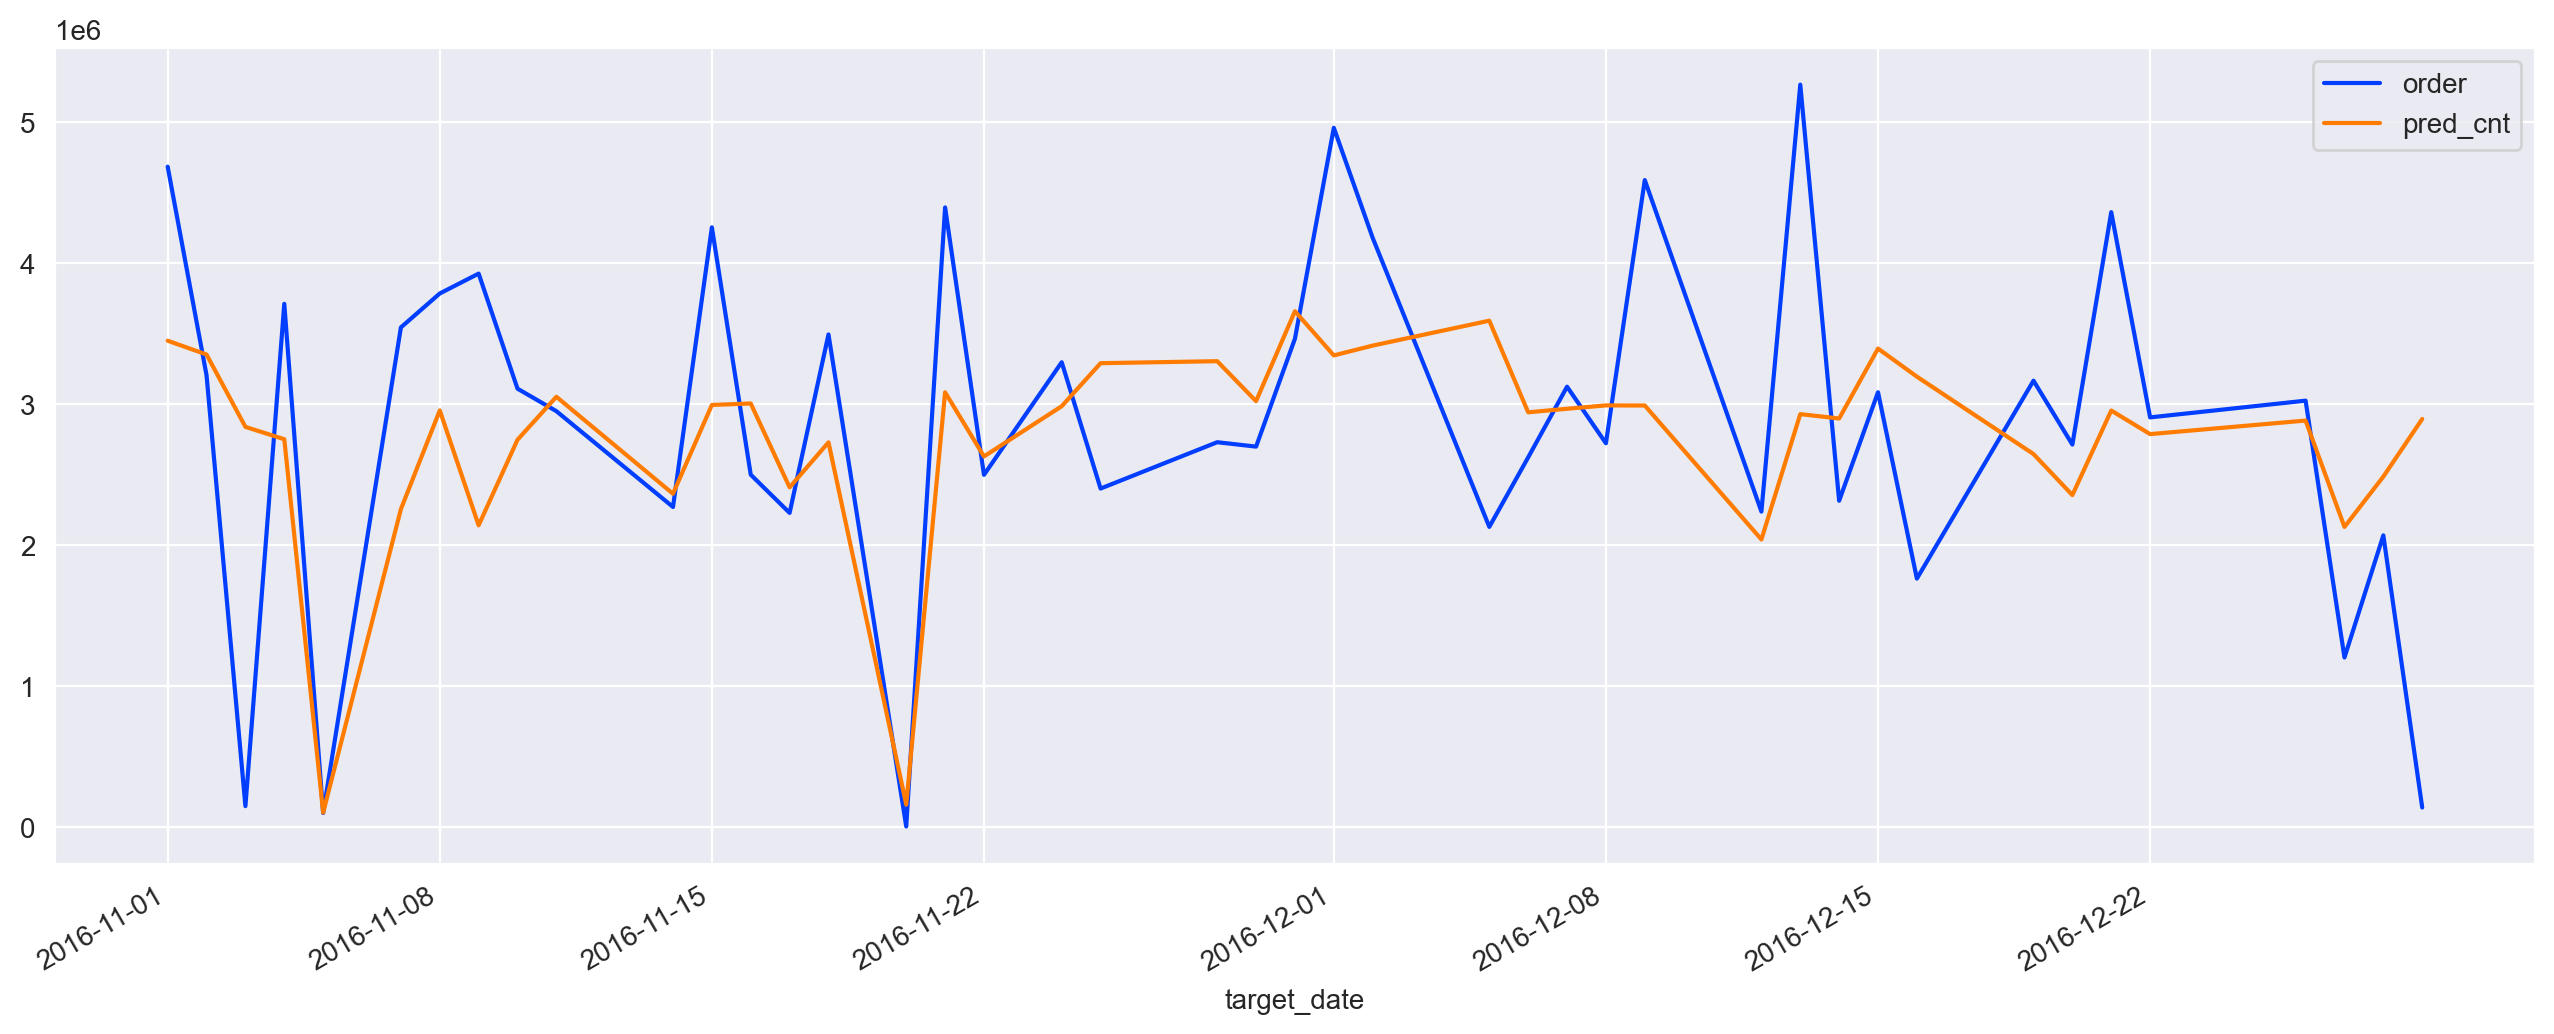

In [7]:
pred_res.query("warehouse == 'Whse_J'")[['order','pred_cnt']].plot(figsize=(16,6))

<Axes: xlabel='target_date'>

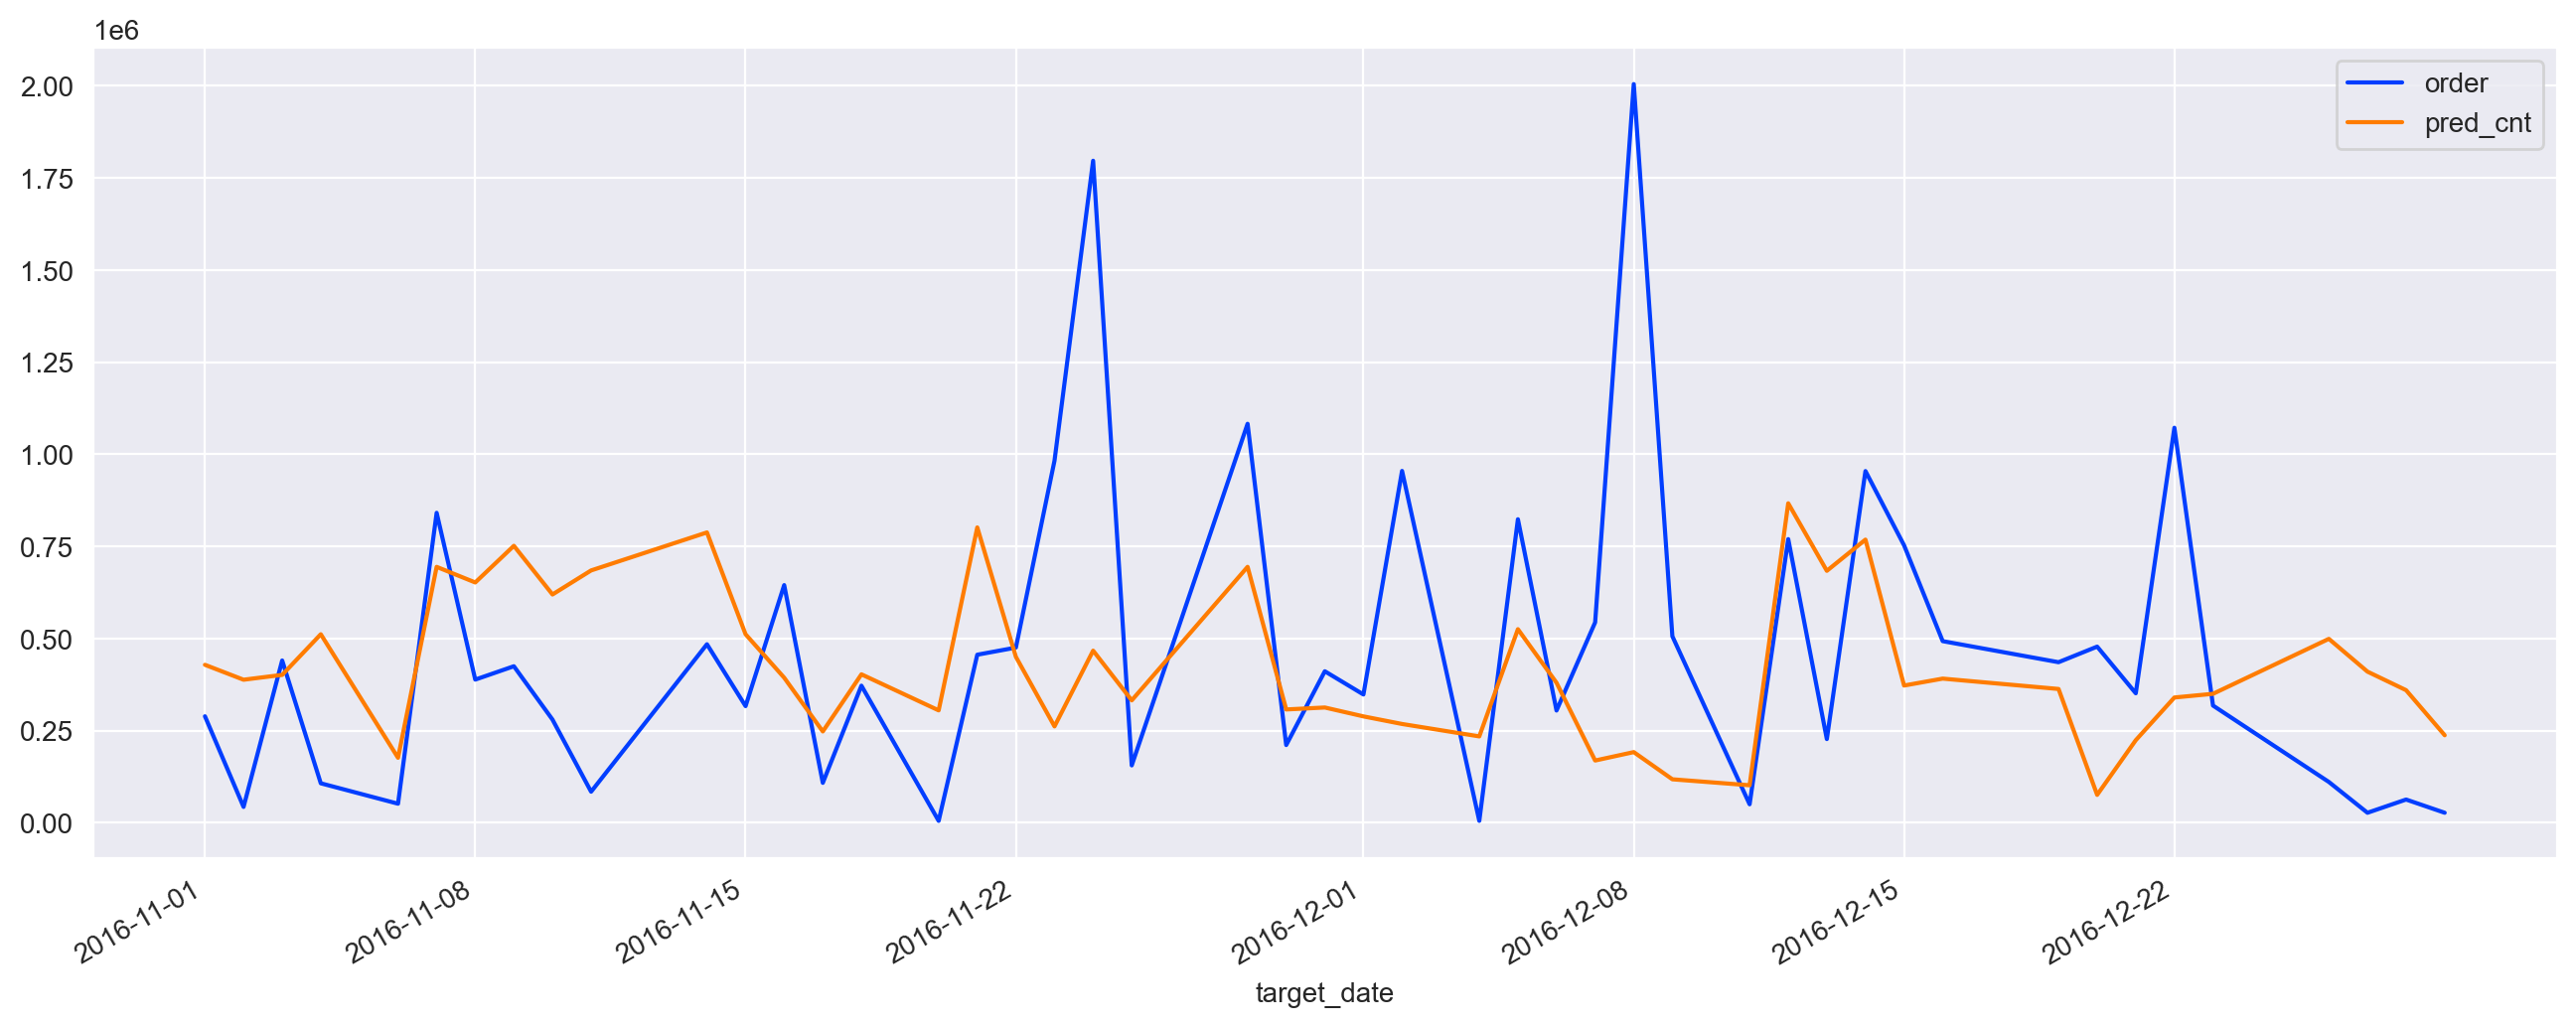

In [8]:
pred_res.query("warehouse == 'Whse_C'")[['order','pred_cnt']].plot(figsize=(16,6))

In [26]:
df

,warehouse,order,month,day,weekend_yn,dayofyear,week_no,week_num,dayofweek_Friday,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,ord_cnt_w1,ord_cnt_w2,ord_cnt_w3,ord_cnt_w4,ord_cnt_w5,ord_cnt_w6,ord_cnt_w7,ord_cnt_cum_w1,ord_cnt_cum_w2,ord_cnt_cum_w3,ord_cnt_cum_w4,ord_cnt_cum_w5,ord_cnt_cum_w6,ord_cnt_cum_w7,ord_cnt_change_w1,ord_cnt_change_w2,ord_cnt_change_w4,ord_cnt_change_w6,ord_ratio_w1,ord_ratio_w2,ord_ratio_w3,ord_ratio_w4,ord_ratio_w5,ord_ratio_w6,ord_ratio_w7
target_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-02,Whse_A,500,1,0,0,2,1,2,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-03,Whse_A,152892,1,1,0,3,1,2,0,0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,Whse_A,69163,1,2,0,4,1,2,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,Whse_A,38834,1,3,0,5,1,2,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-06,Whse_A,103533,1,4,0,6,1,2,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-26,Whse_S,444726,12,0,0,361,52,5,0,1,0,0,0,0,0,87419.0,174892.0,184323.0,588184.0,276873.0,254783.0,320849.0,4901201.0,3422989.0,2042005.0,9251986.0,6564460.0,3743474.0,1869451.0,0.431848,0.676288,0.409405,0.500611,0.017836,0.051093,0.090266,0.063574,0.042178,0.068061,0.171627
2016-12-27,Whse_S,431475,12,1,0,362,52,5,0,0,0,0,0,1,0,205597.0,298890.0,454351.0,850367.0,799514.0,1141027.0,136930.0,5106798.0,3721879.0,2496356.0,10102353.0,7363974.0,4884501.0,2006381.0,0.372102,0.490925,0.371862,0.589235,0.040259,0.080306,0.182006,0.084175,0.108571,0.233602,0.068247
2016-12-28,Whse_S,609080,12,2,0,363,52,5,0,0,0,0,0,0,1,22001.0,208030.0,11336.0,1558610.0,270610.0,180000.0,7850.0,5128799.0,3929909.0,2507692.0,11660963.0,7634584.0,5064501.0,2014231.0,0.305068,0.567142,0.527387,0.602284,0.004290,0.052935,0.004520,0.133660,0.035445,0.035542,0.003897


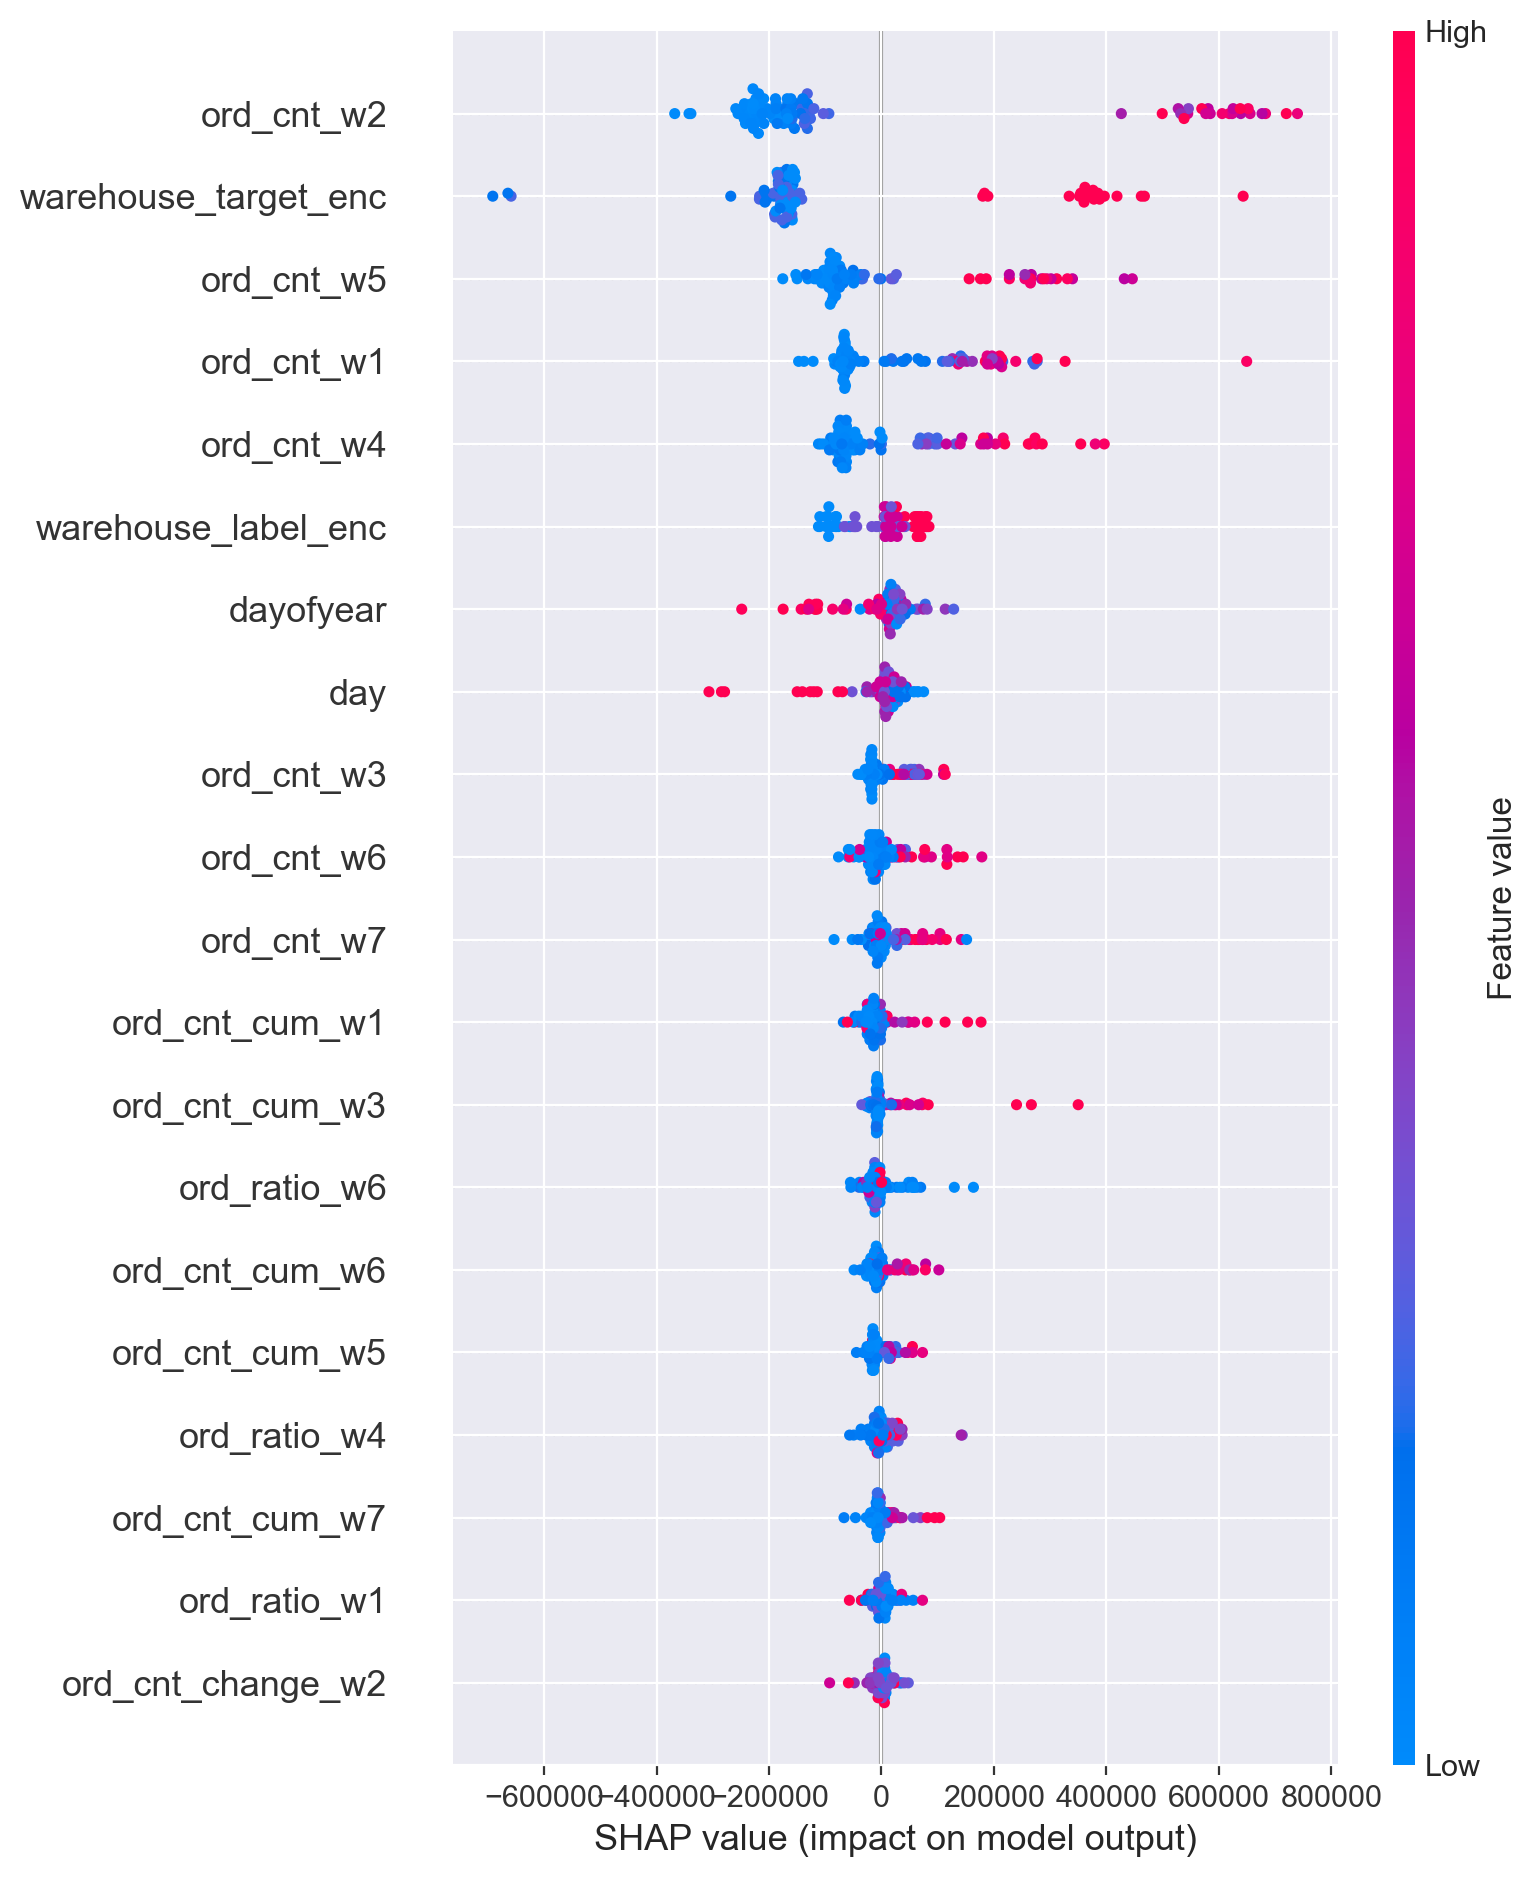

In [25]:
# shap value check
train = df[df.index < self.shap_cut_date]
pred = df[df.index >= self.shap_cut_date]

train['warehouse_label_enc'] = self.label_encoder.fit_transform(train['warehouse'])
train['warehouse_target_enc'] = self.target_encoder.fit_transform(train['warehouse'], train['order'])
train = train.drop("warehouse", axis=1)
X_train = train.drop("order", axis=1)
y_train = train[['order']]

# 성능 체크 용도
pred['warehouse_label_enc'] = self.label_encoder.transform(pred['warehouse'])
pred['warehouse_target_enc'] = self.target_encoder.transform(pred['warehouse'], pred['order'])
X_pred = pred.drop(["order", "warehouse"], axis=1)
y_pred = pred[['warehouse','order']]        

model = self.base_model
model.fit(X_train, y_train)
y_pred['pred_cnt'] = model.predict(X_pred).astype(int)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_pred)        
shap.summary_plot(shap_values, X_pred)      

## Model Evaluation

<Axes: xlabel='target_date'>

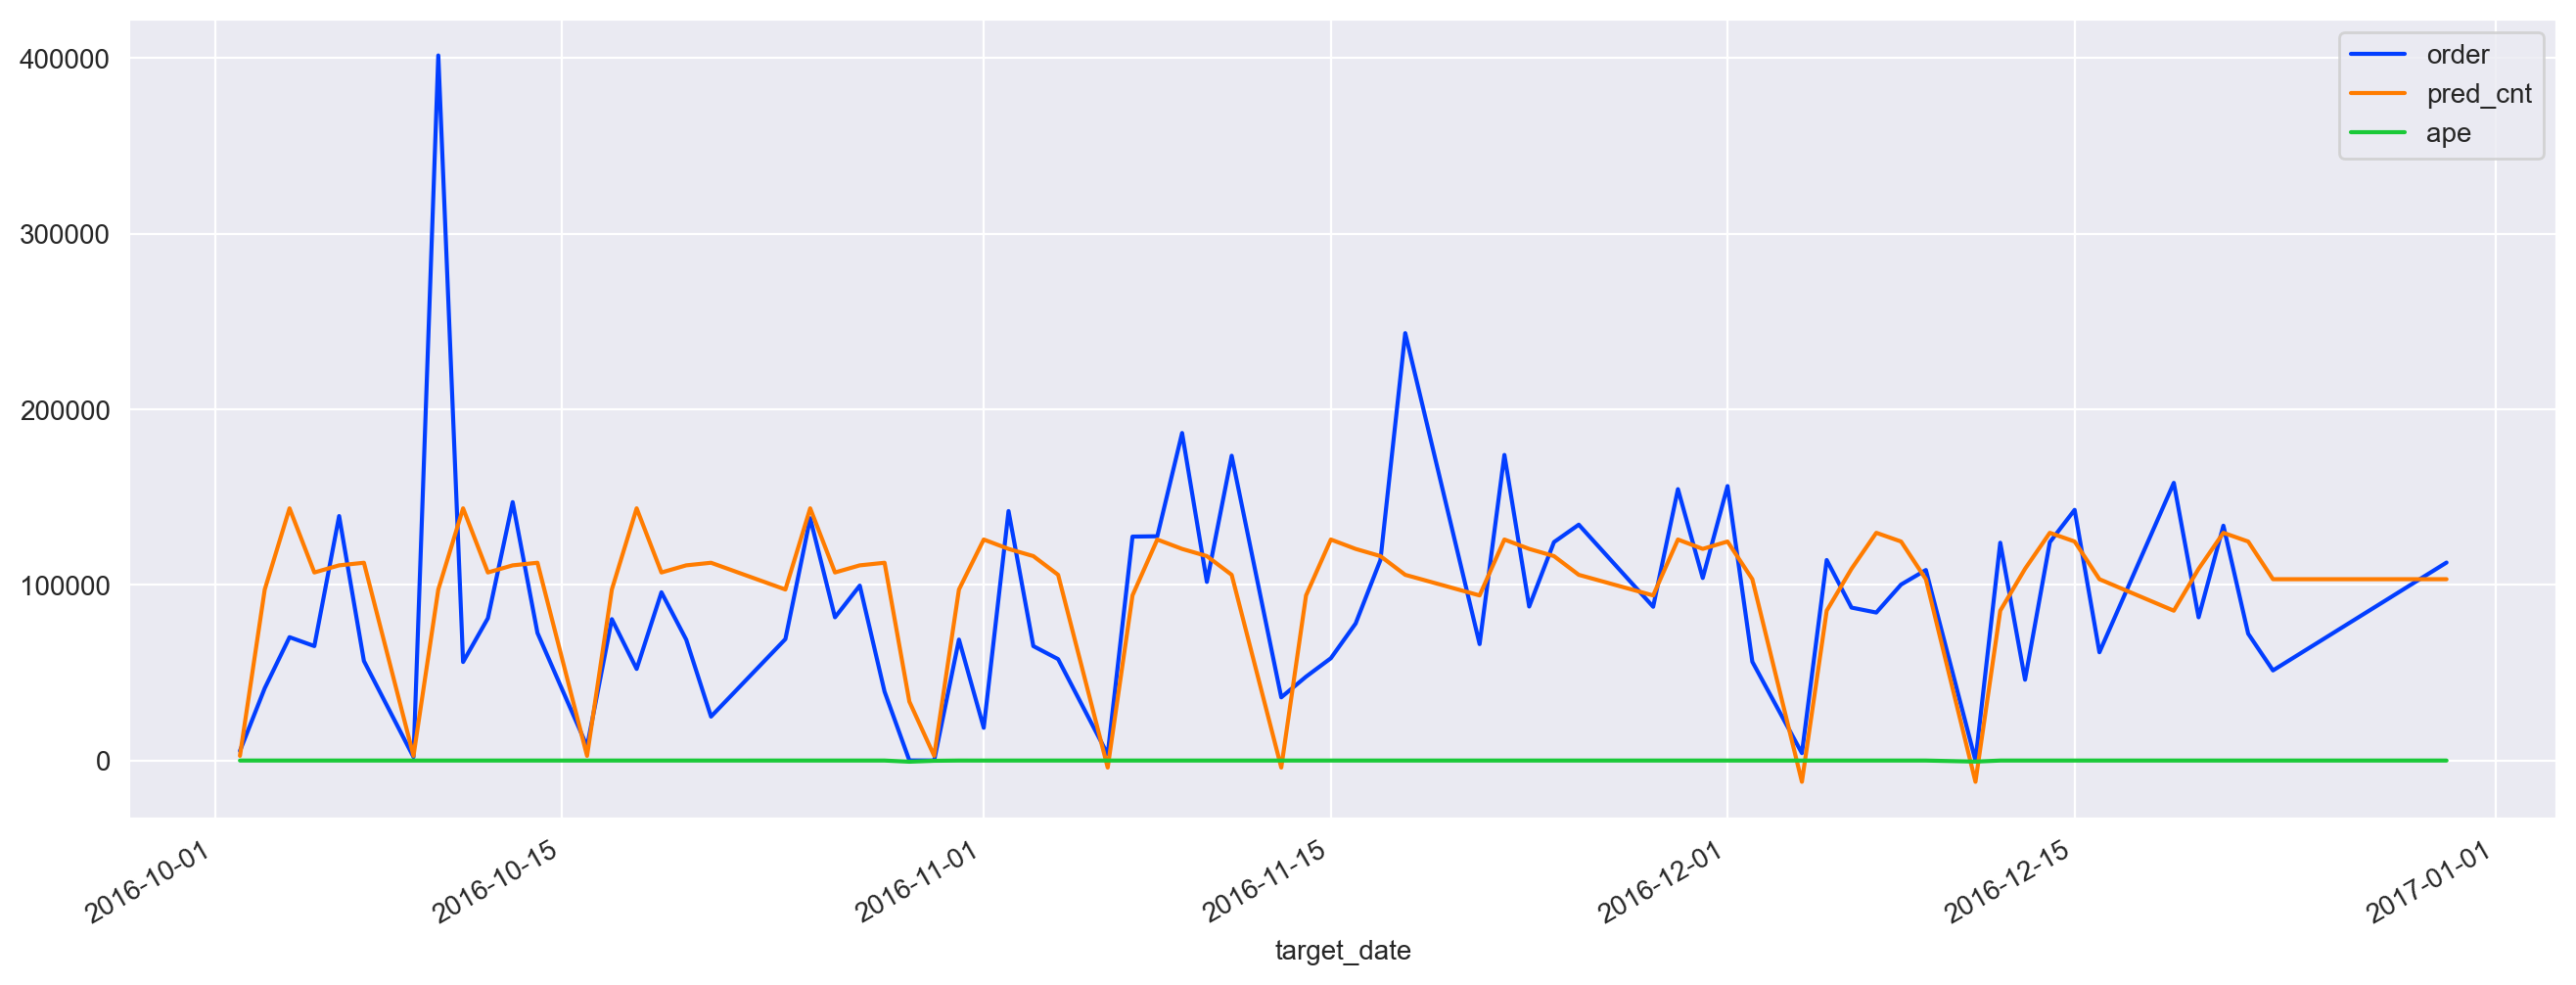

In [26]:
pred_res.query("warehouse == 'Whse_A'").plot(figsize=(16,6))

<Axes: xlabel='target_date'>

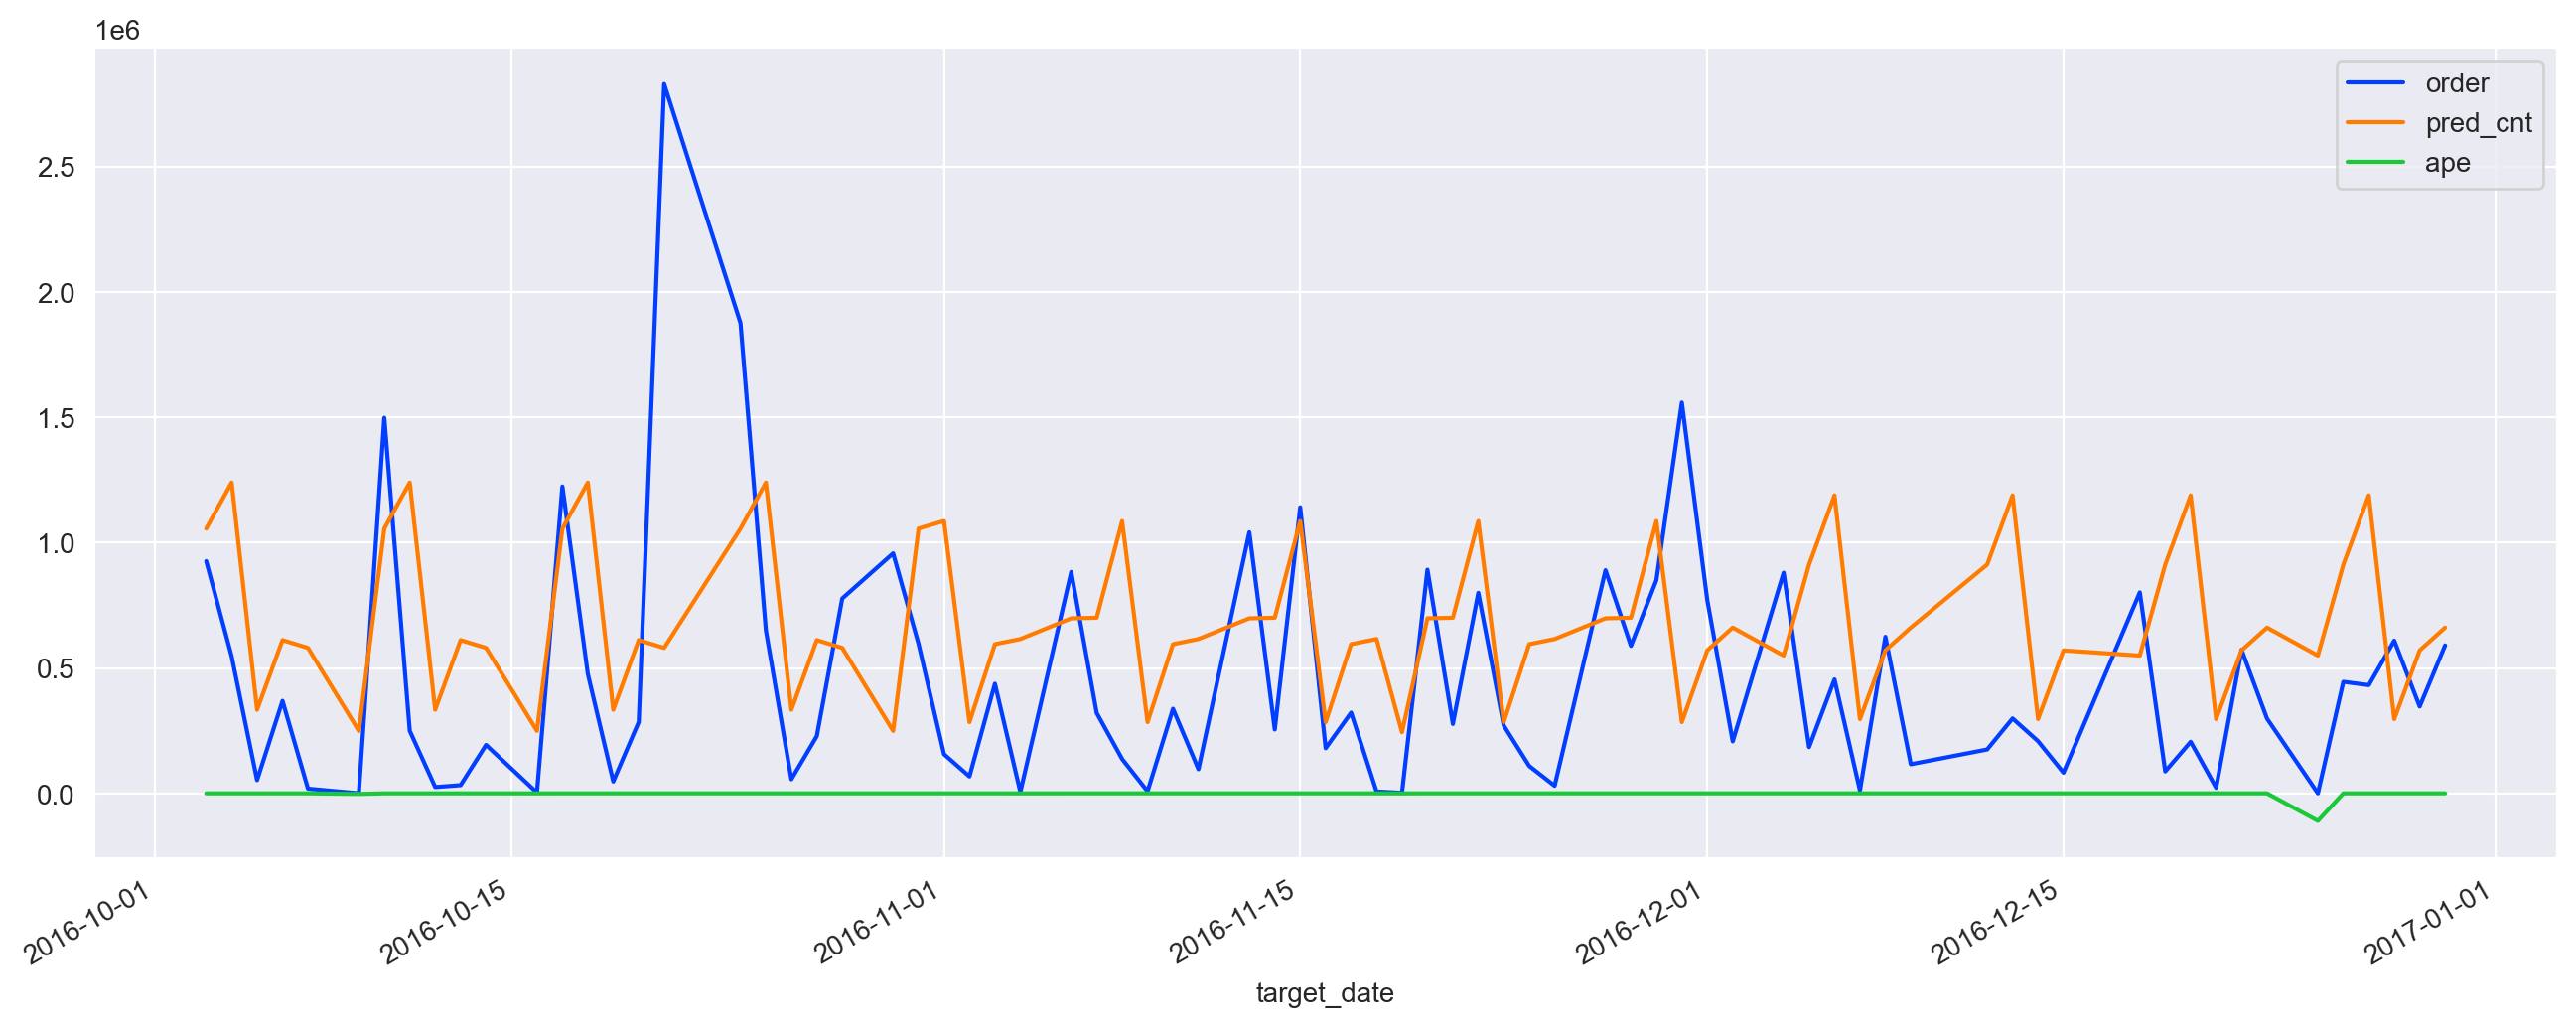

In [27]:
pred_res.query("warehouse == 'Whse_S'").plot(figsize=(16,6))

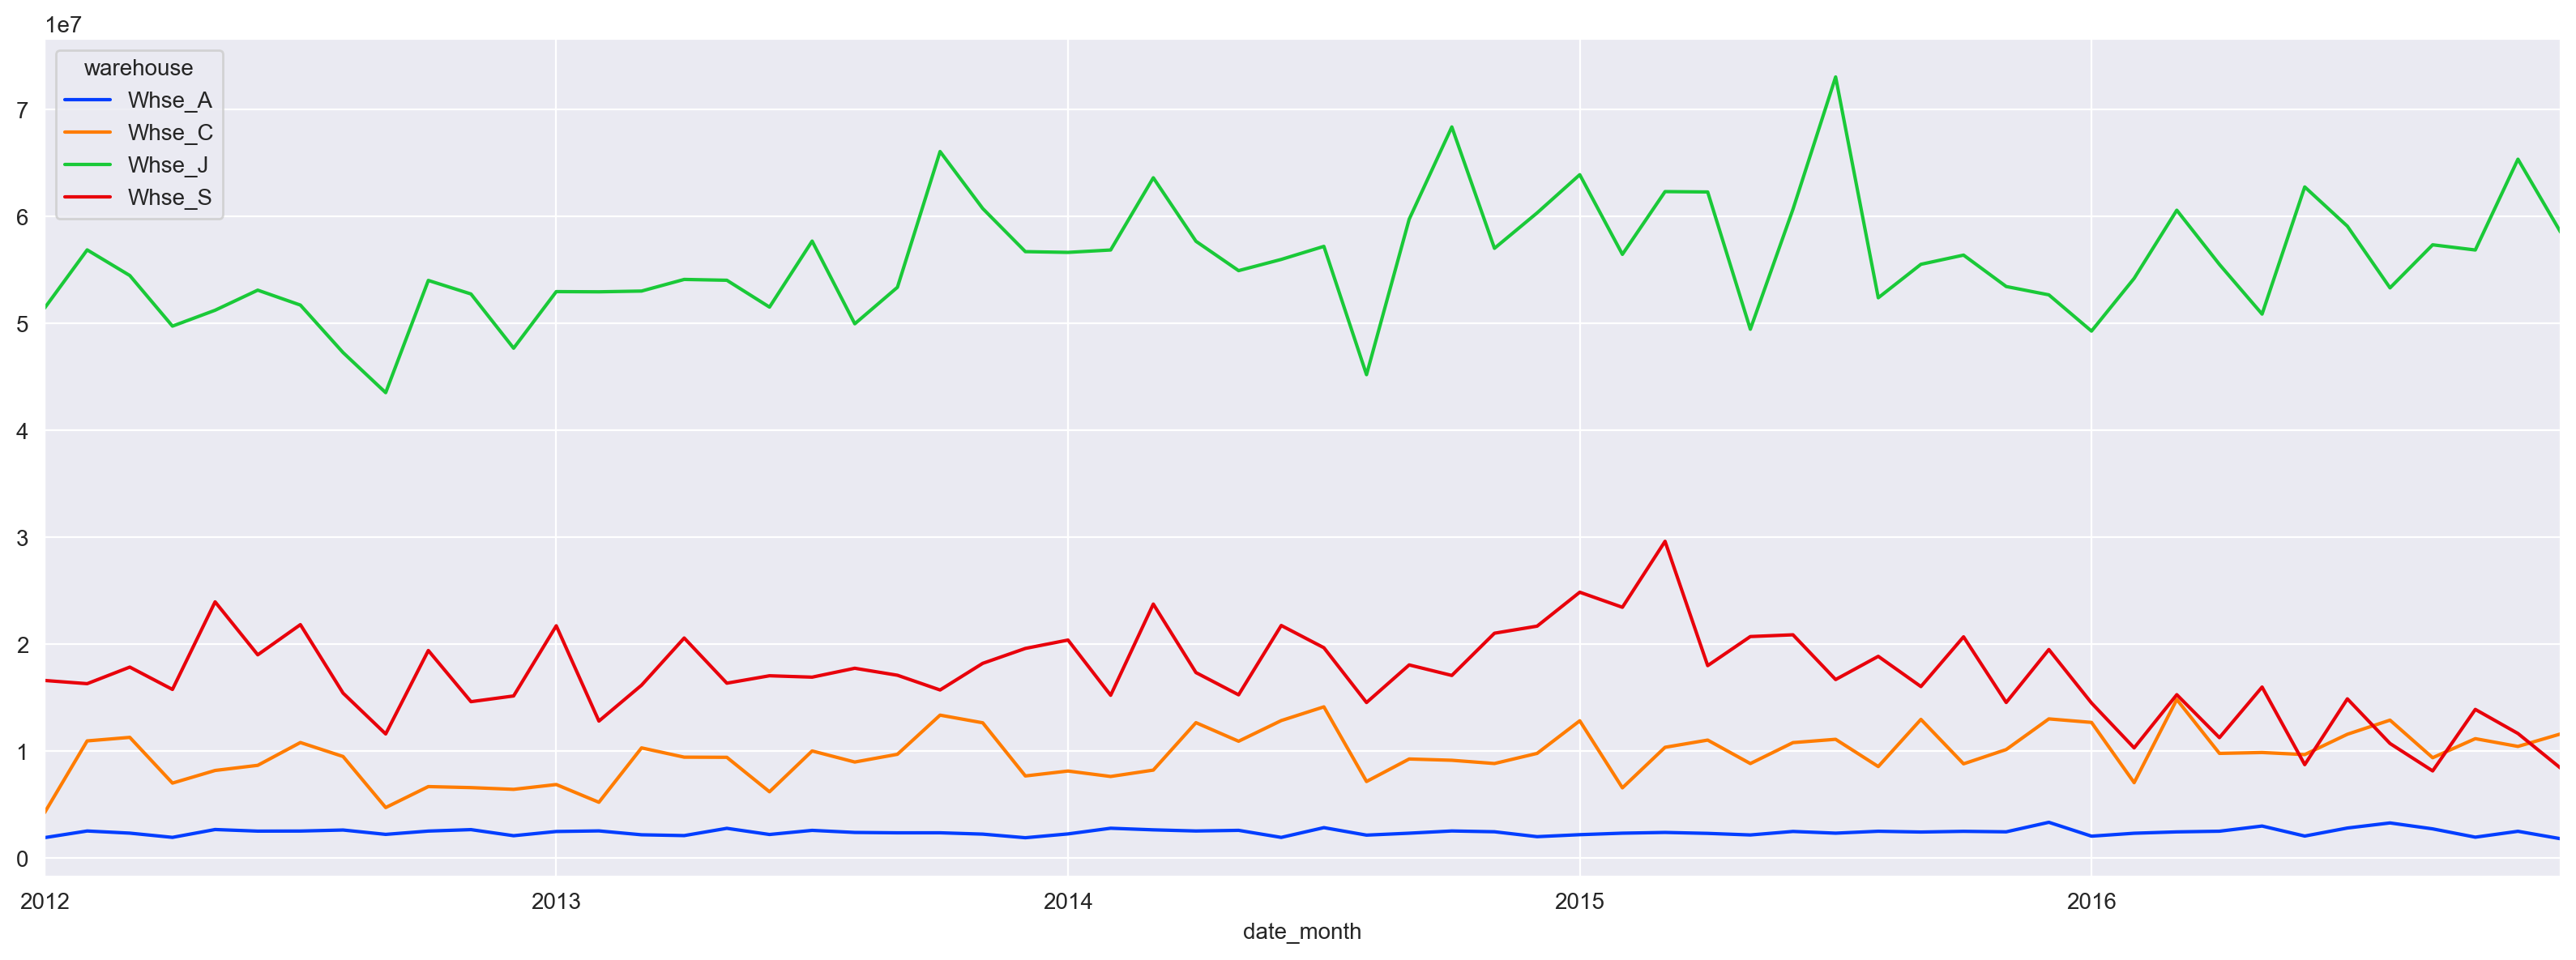

In [24]:
# 센터별 주문수 체크
df.groupby(['date_month', 'warehouse']).order.sum().unstack().plot(figsize=(16,6))
plt.tight_layout()

In [158]:
# daily to monthly or
# sum after daily base predict 

In [161]:
df = df.groupby(['warehouse', 'date'])['order'].sum().reset_index()

In [183]:
df

,prd_code,warehouse,category,date,order,date_month,day
0,Product_0993,Whse_J,Category_028,2012-07-27,100,2012-07-01,Friday
1,Product_0979,Whse_J,Category_028,2012-01-19,500,2012-01-01,Thursday
2,Product_0979,Whse_J,Category_028,2012-02-03,500,2012-02-01,Friday
3,Product_0979,Whse_J,Category_028,2012-02-09,500,2012-02-01,Thursday
4,Product_0979,Whse_J,Category_028,2012-03-02,500,2012-03-01,Friday
...,...,...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016-04-27,1000,2016-04-01,Wednesday
1048571,Product_1974,Whse_J,Category_006,2016-04-27,1,2016-04-01,Wednesday
1048572,Product_1787,Whse_J,Category_006,2016-04-28,2500,2016-04-01,Thursday
1048573,Product_0901,Whse_J,Category_023,2016-10-07,50,2016-10-01,Friday


In [ ]:
sns.swarmplot(data=df, x="day", y='order', hue="day")

KeyboardInterrupt: 

<Axes: xlabel='day'>

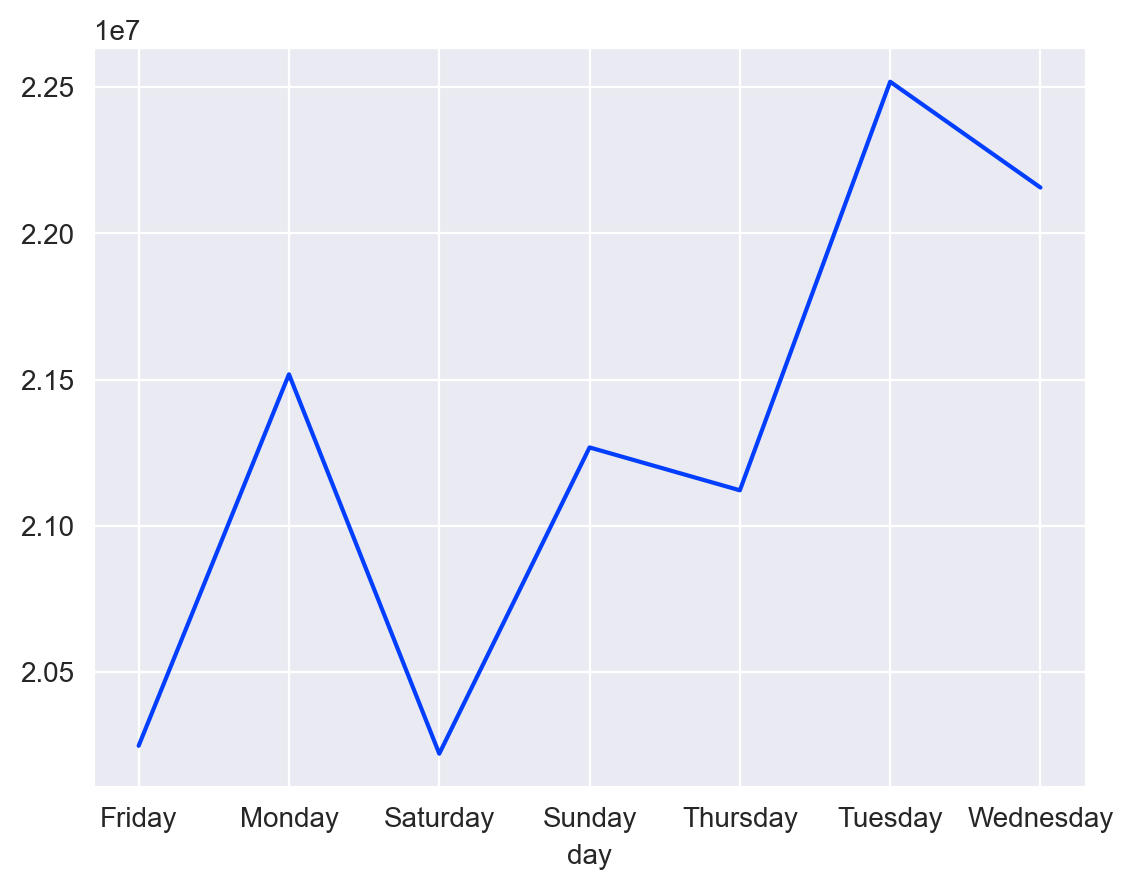

In [171]:
df.groupby(['day'])['order'].mean().plot()

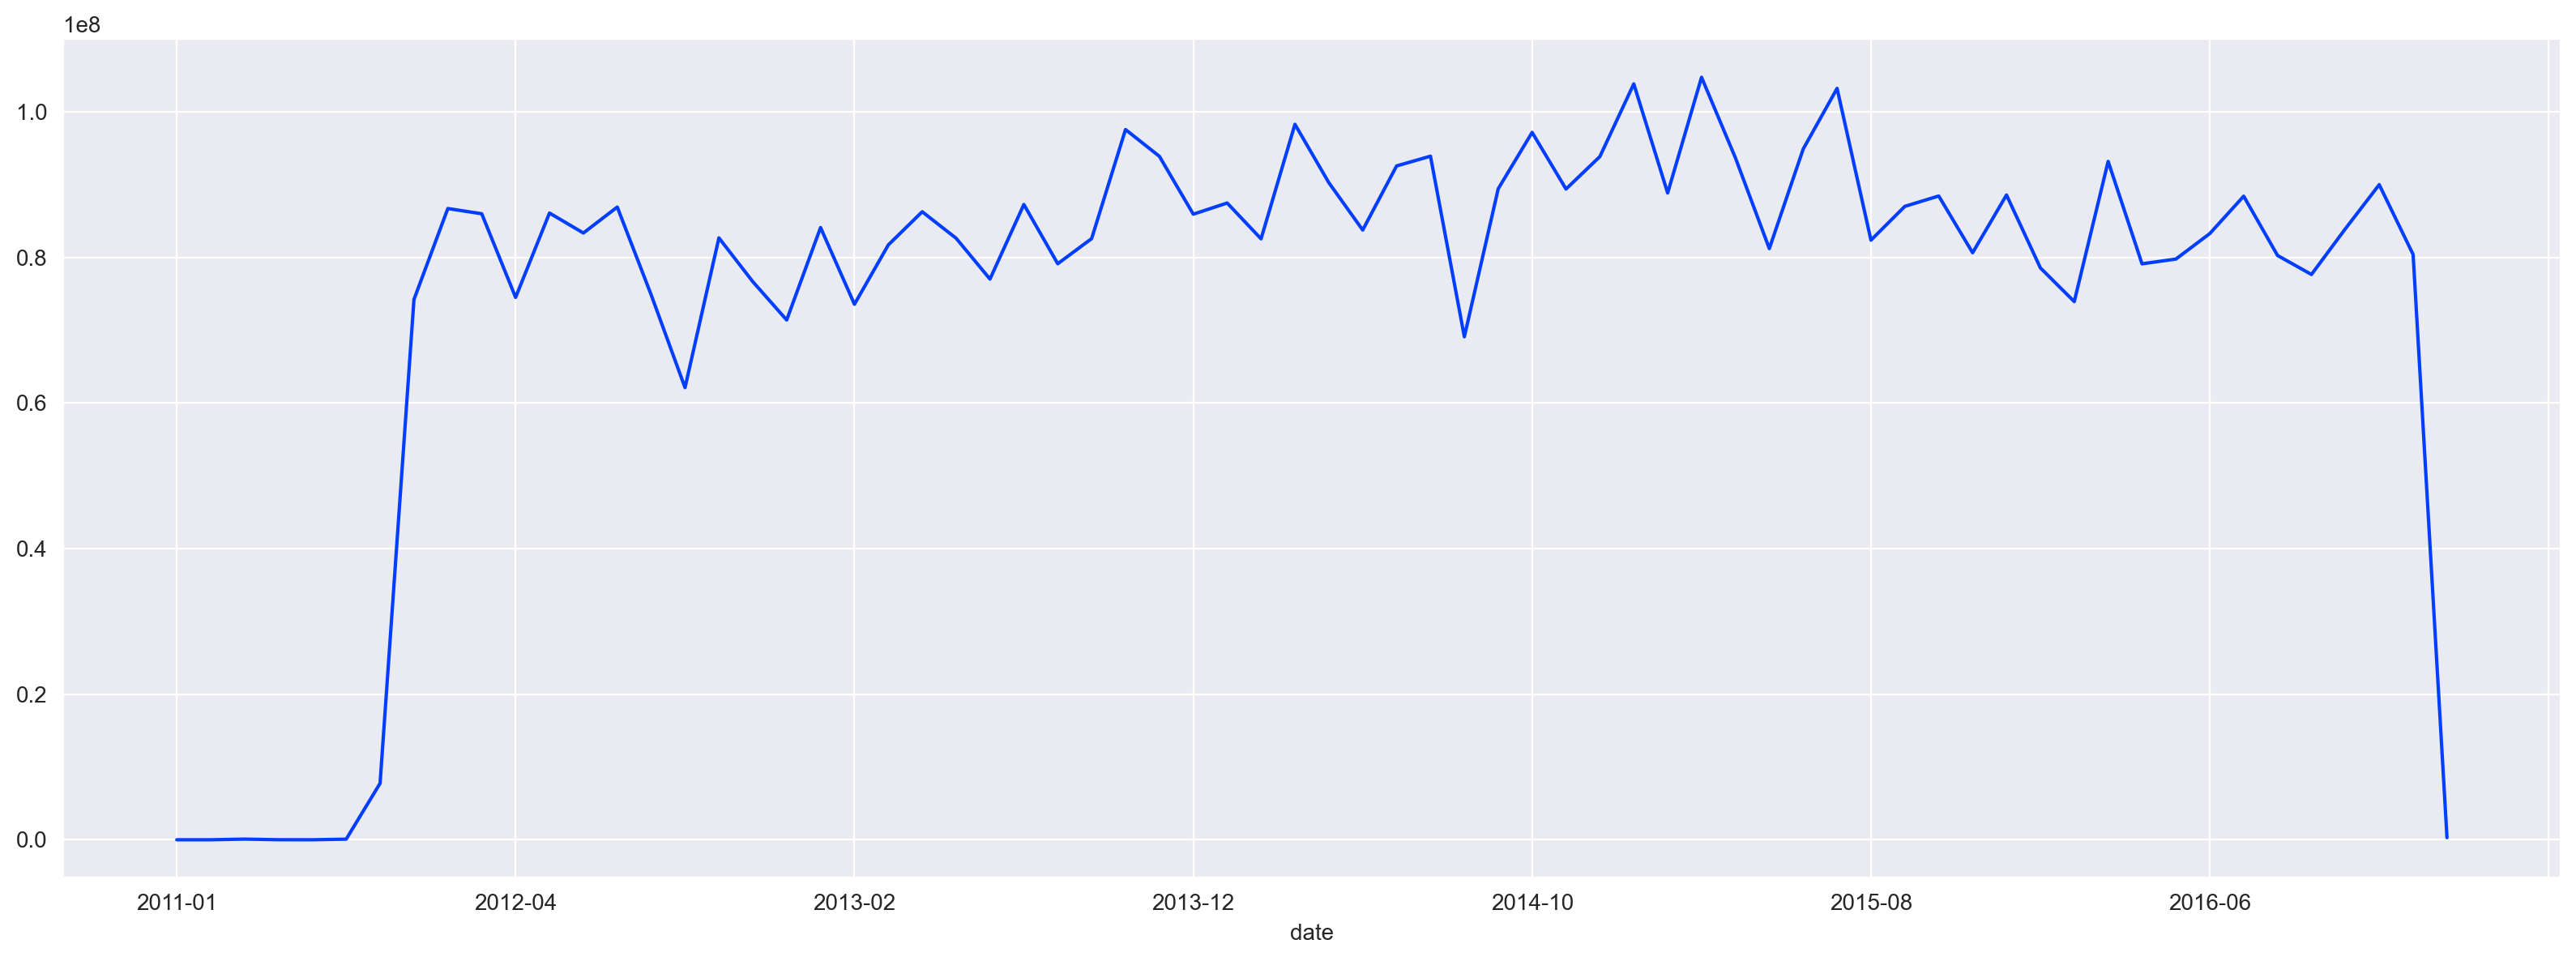

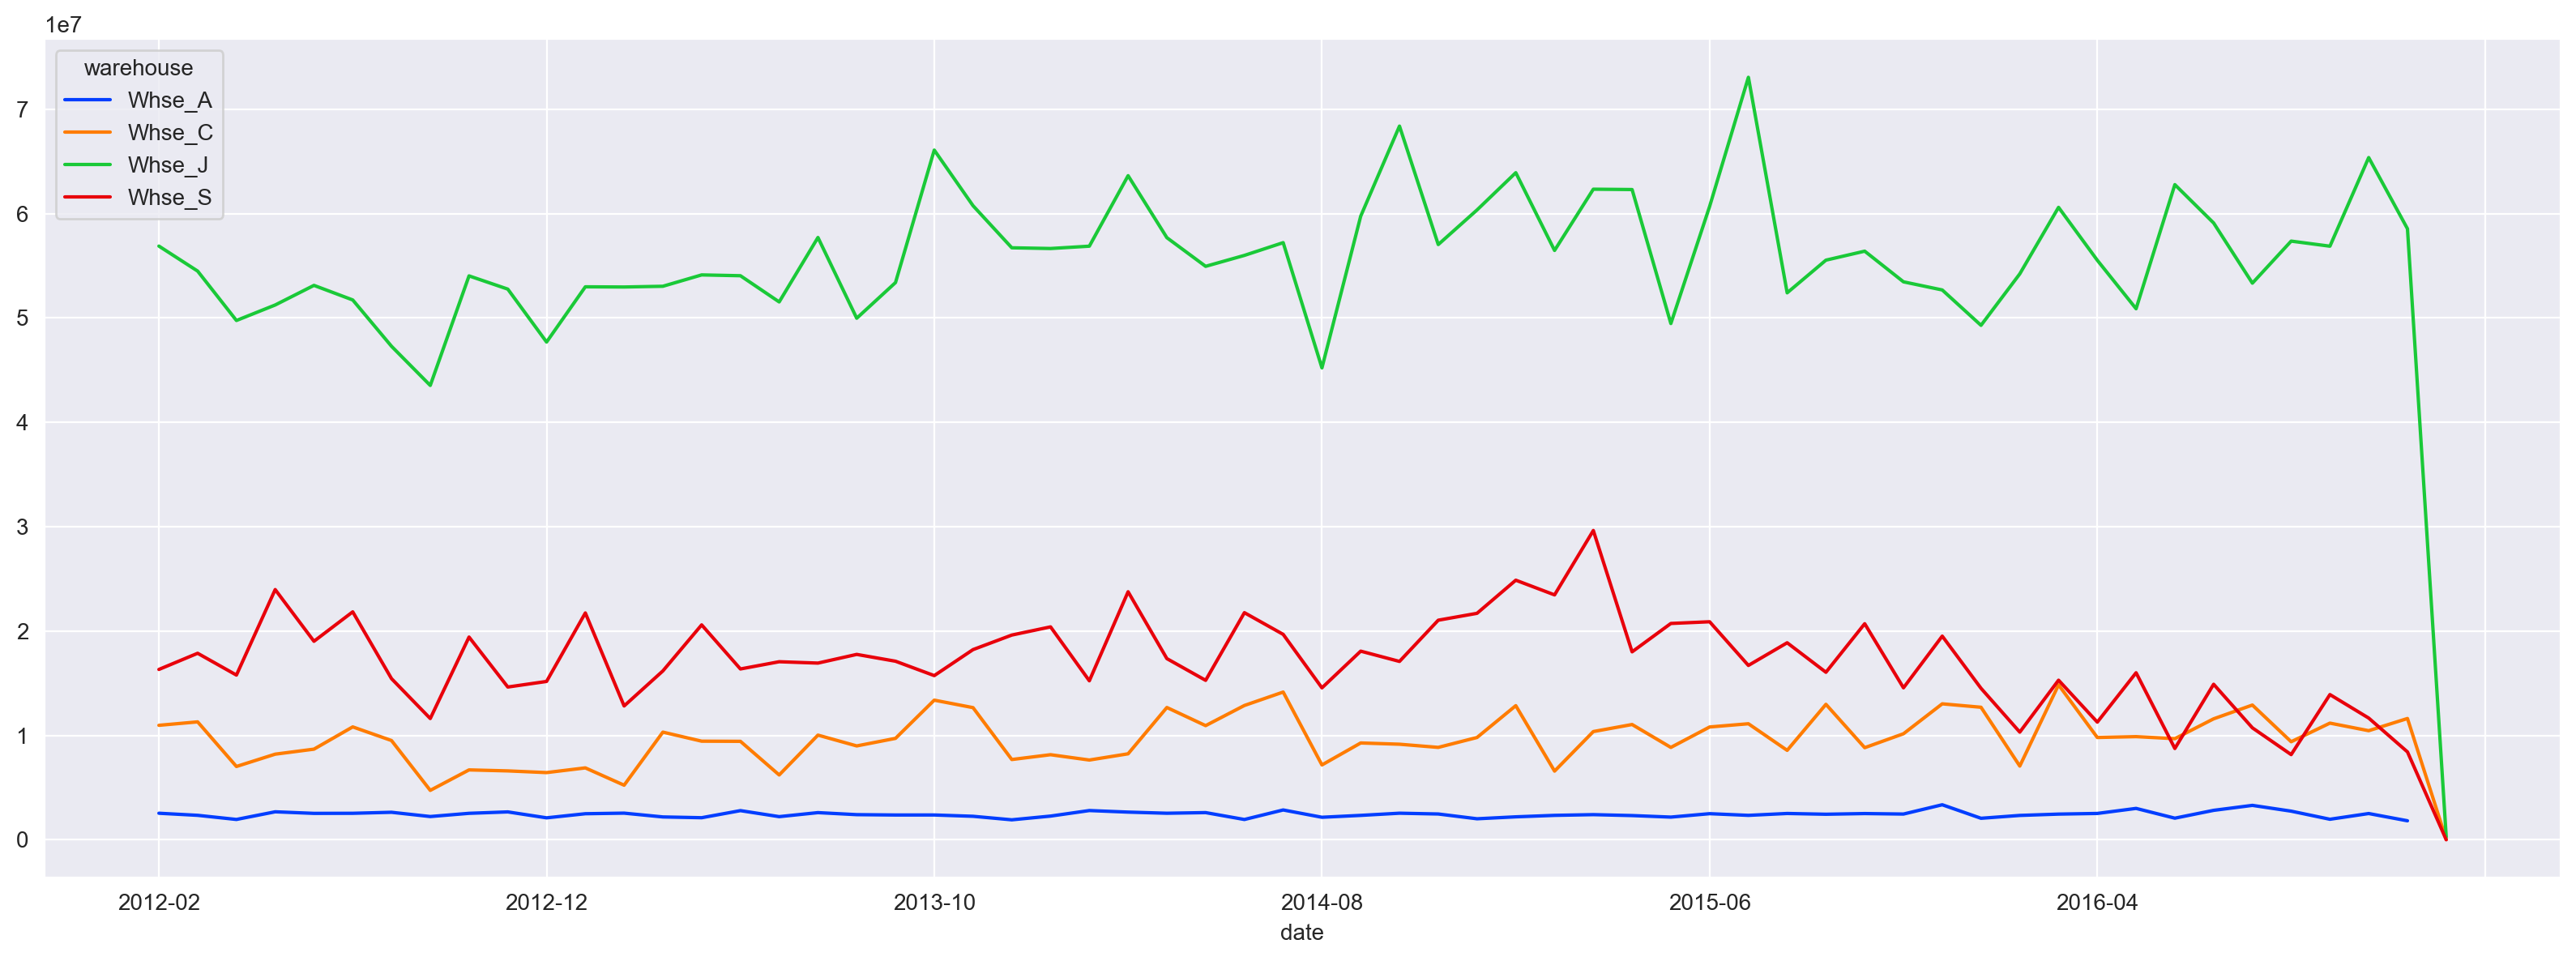

In [102]:
df.groupby(['date', 'warehouse']).order.sum().unstack().plot(figsize=(16,6))
plt.tight_layout()

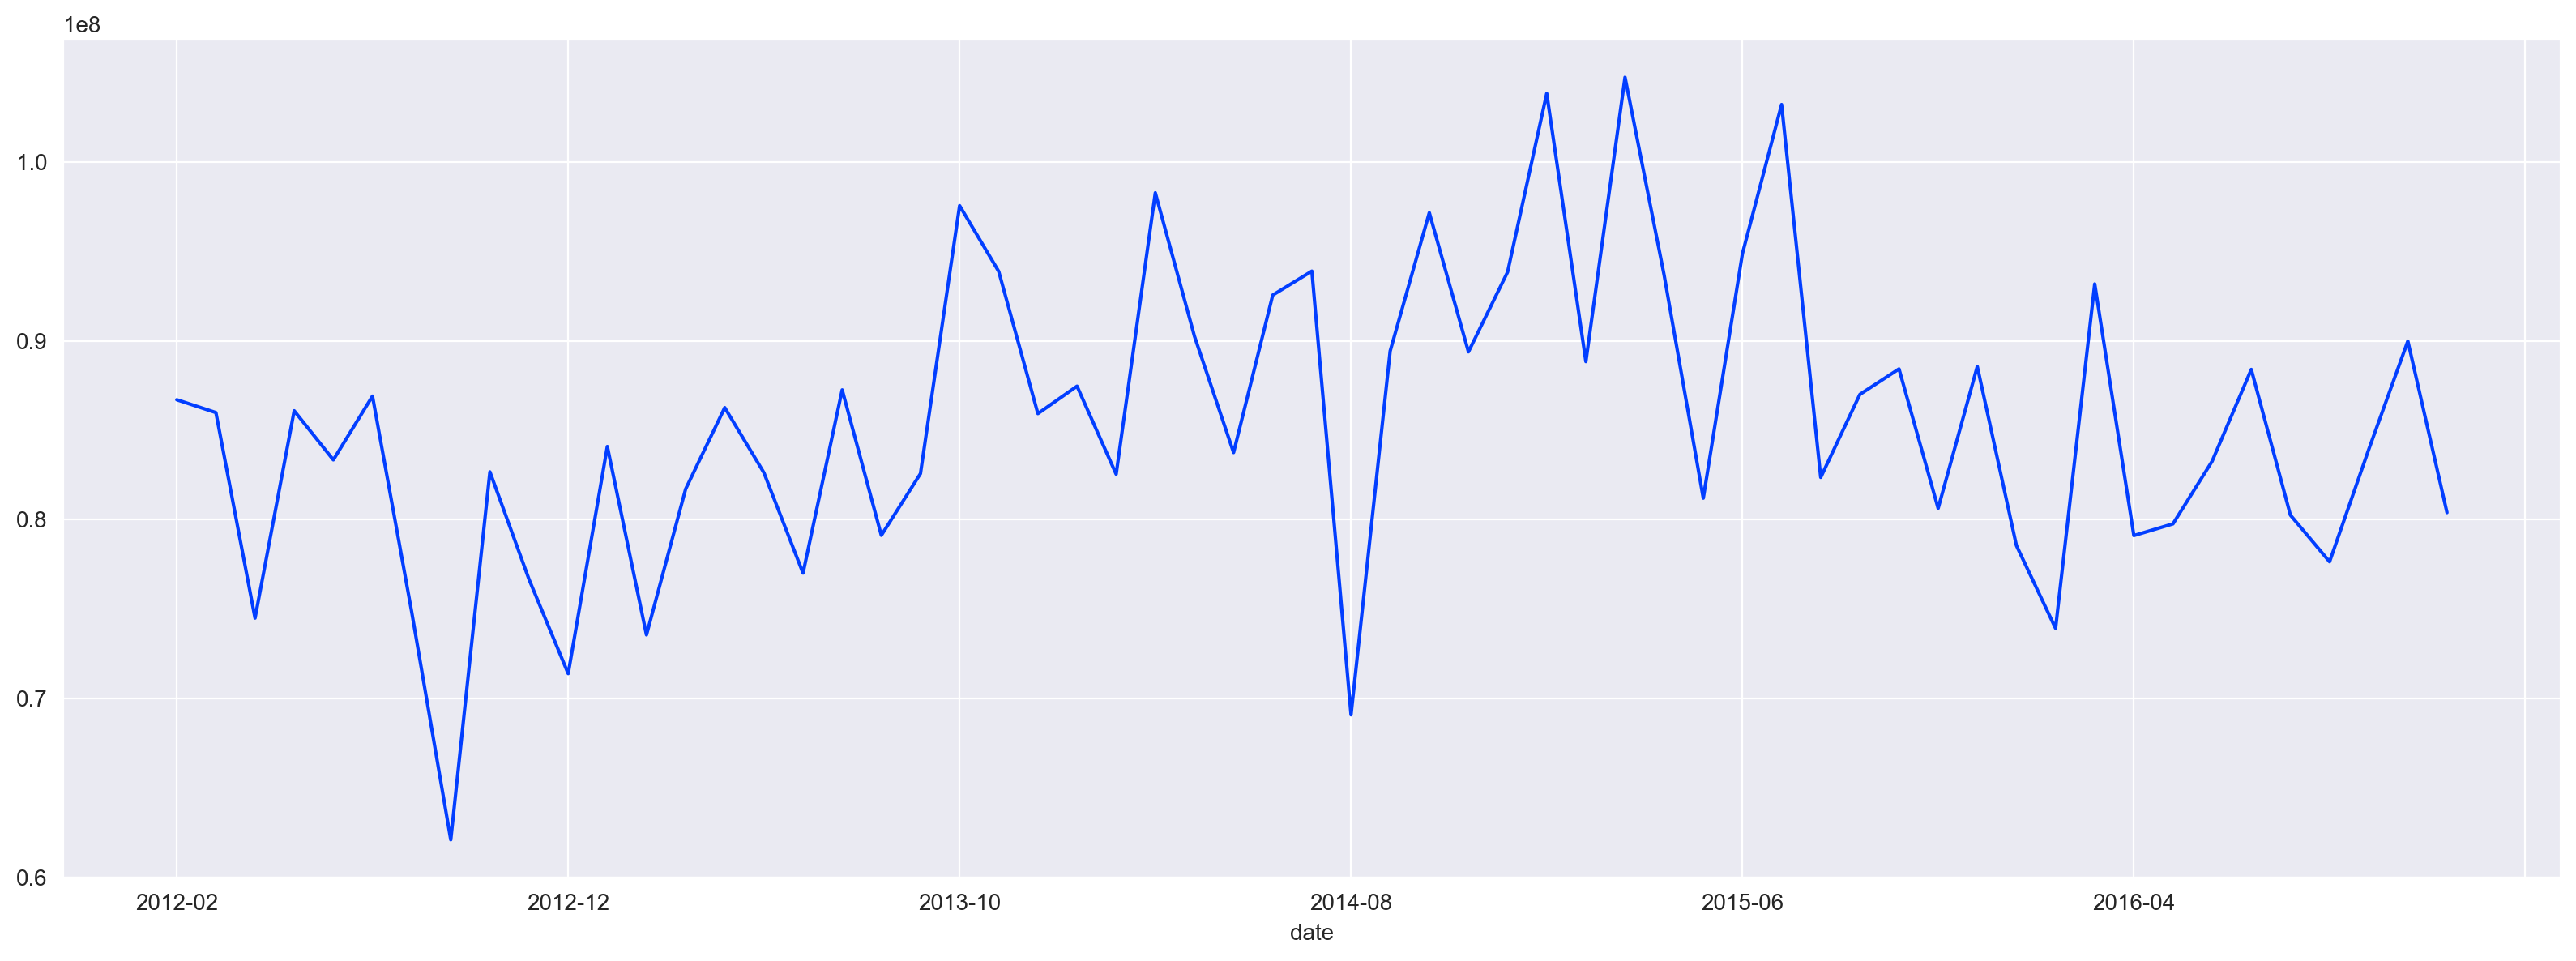

In [118]:
df.groupby(['date']).order.sum().plot(figsize=(16,6))
plt.tight_layout()

In [ ]:
# 12년 이전 는 수치가 너무 적어서 제외
# 데이터수집을 12년부터 시작한듯

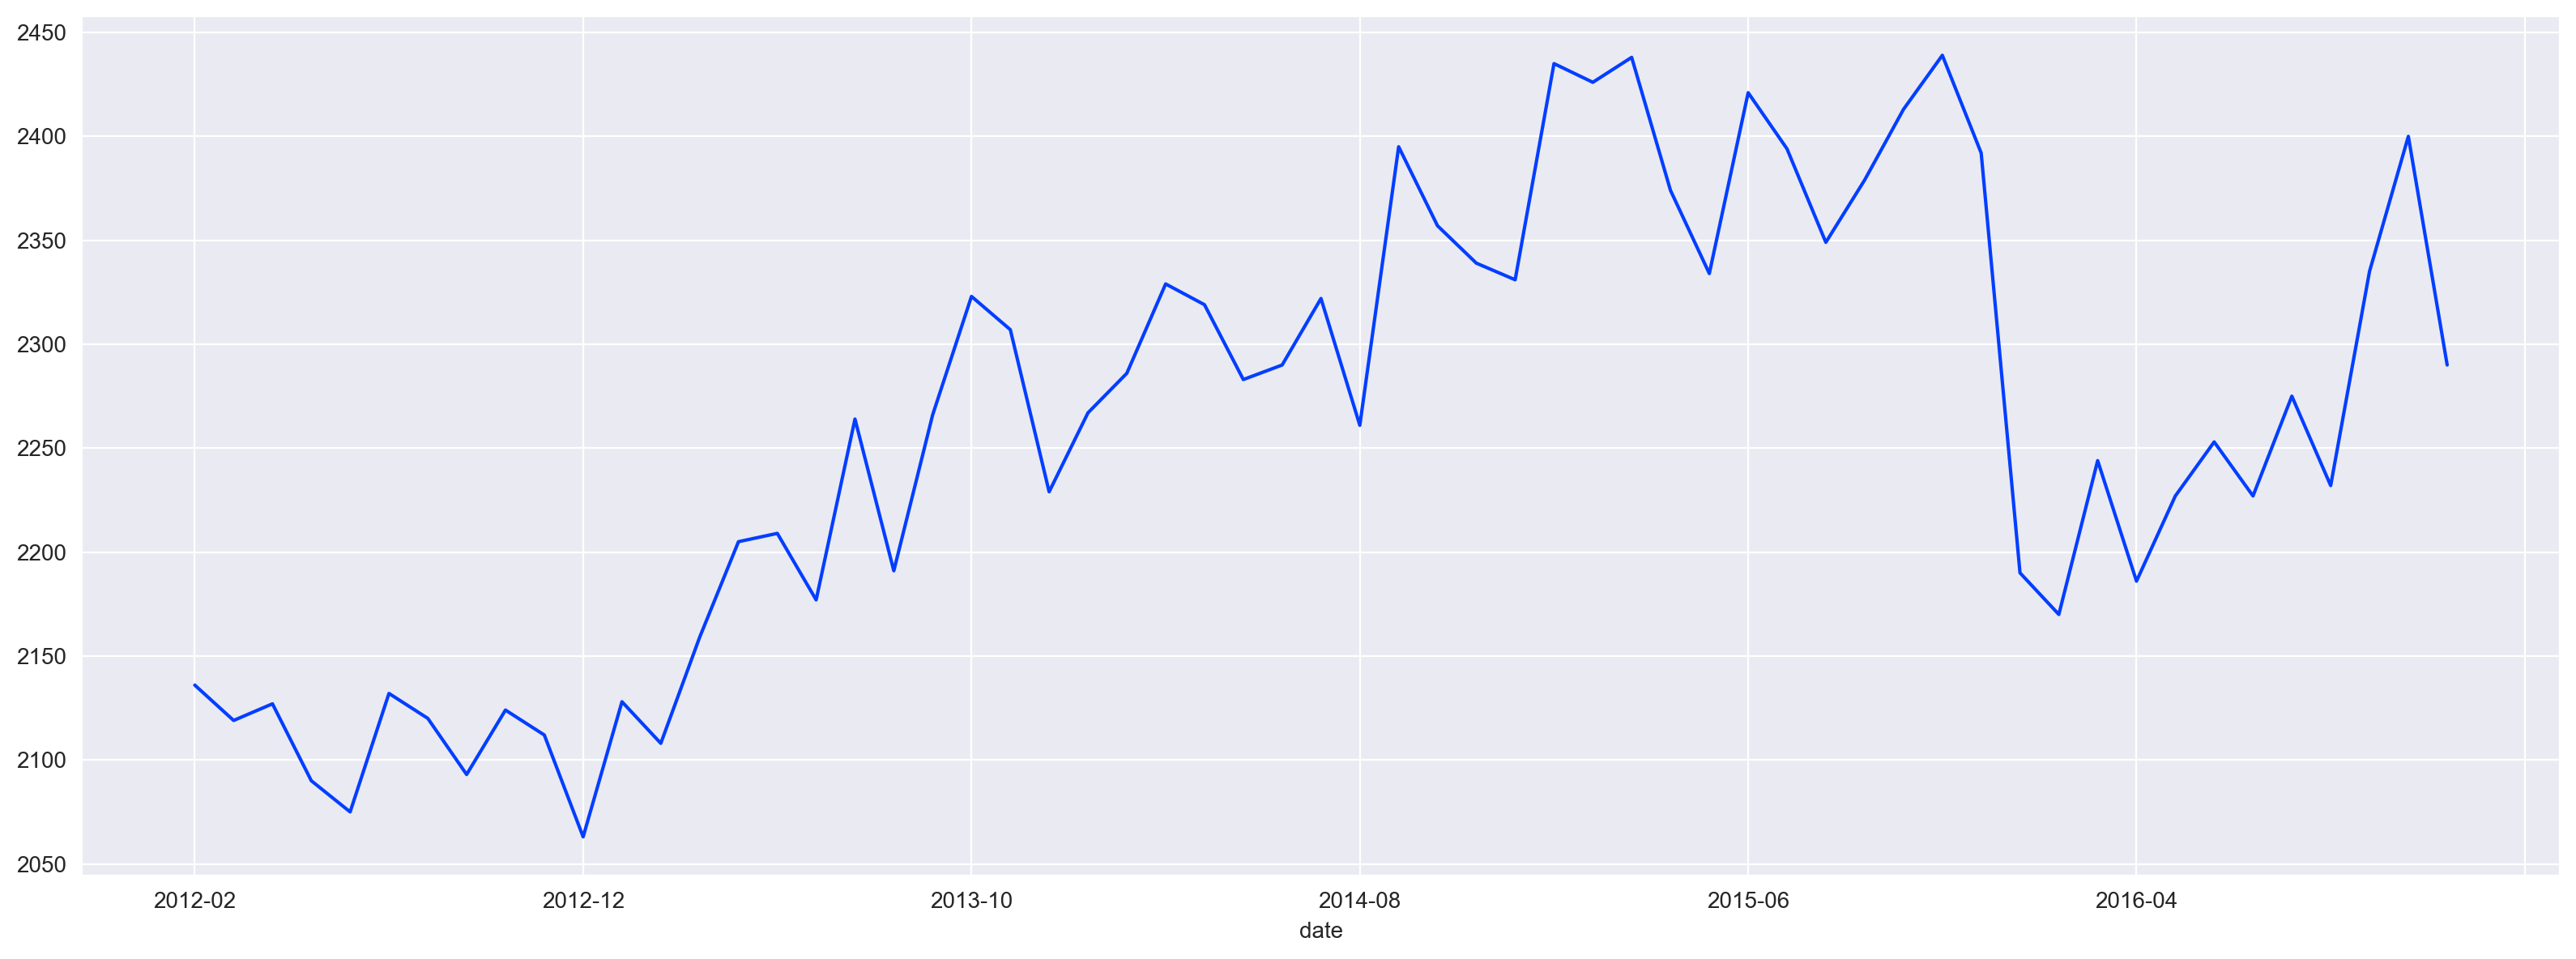

In [120]:
df.groupby('date').order.size().plot(figsize=(16,6))

plt.tight_layout()

In [78]:
print(len(df.prd_code.value_counts())) # 2160개의 상품
print(len(df.warehouse.value_counts())) # 4개 창고
print(len(df.category.value_counts())) # 33개 카테고리

2160
4
33


In [81]:
df.groupby(['warehouse']).order.sum()

warehouse
Whse_A     151152297
Whse_C     583458308
Whse_J    3353861057
Whse_S    1036126159
Name: order, dtype: int64

In [82]:
df.groupby(['category']).order.sum()

category
Category_001       1742936
Category_002           624
Category_003        390697
Category_004         98277
Category_005     199021605
Category_006     403614499
Category_007     128208687
Category_008         17545
Category_009       3695567
Category_010         21836
Category_011       2872254
Category_012         68278
Category_013        305830
Category_014           100
Category_015        823397
Category_016         16850
Category_017         47883
Category_018         45737
Category_019    4235512135
Category_020       2367472
Category_021       4414879
Category_022        599506
Category_023       3326785
Category_024       1045596
Category_025        486000
Category_026        280060
Category_027            80
Category_028      48213229
Category_029         23020
Category_030      40373955
Category_031         12998
Category_032       4459504
Category_033      42490000
Name: order, dtype: int64

In [83]:
df.groupby(['warehouse']).order.describe() # stats by center

,count,mean,std,min,25%,50%,75%,max
warehouse,,,,,,,,
Whse_A,147179.0,1026.996358,4340.340863,0.0,3.0,68.0,600.0,396200.0
Whse_C,42237.0,13813.914530,59429.217488,0.0,100.0,1000.0,6000.0,3000000.0
Whse_J,760892.0,4407.801708,21185.397316,0.0,25.0,300.0,2000.0,3000000.0
Whse_S,87798.0,11801.250131,65018.567415,0.0,30.0,500.0,4000.0,4000000.0


<Axes: >

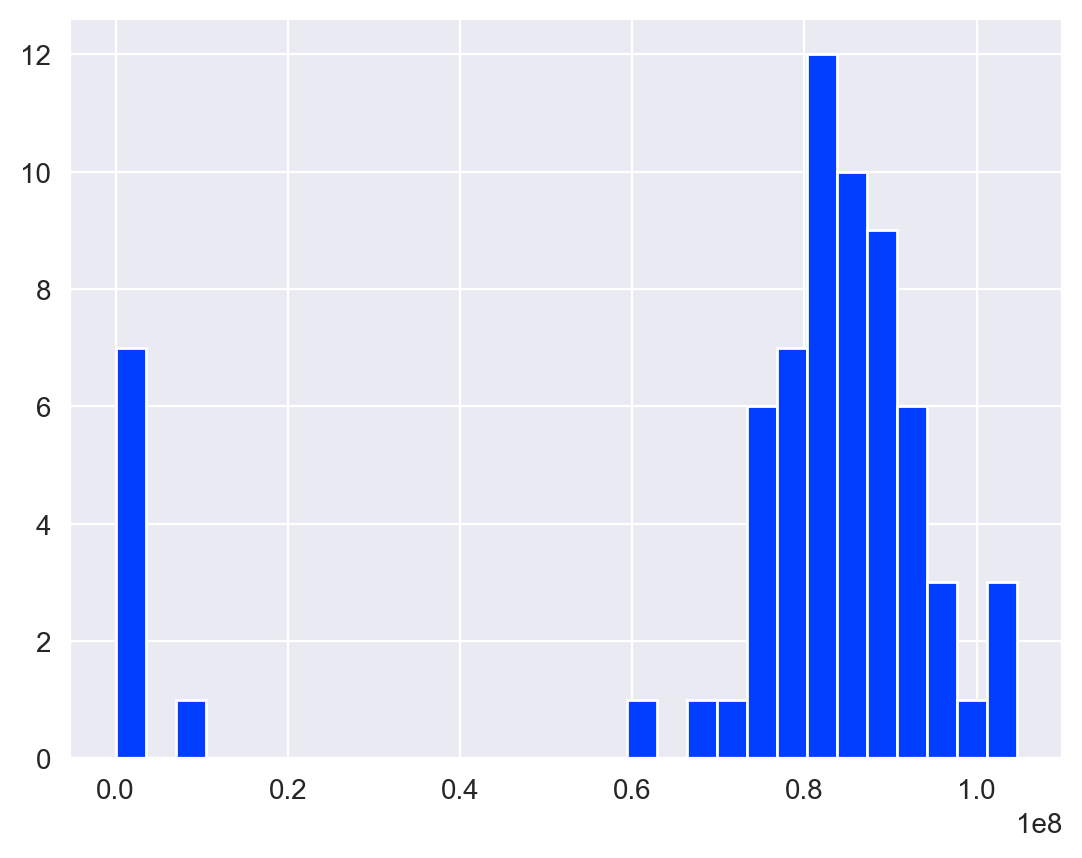

In [88]:
df_whse_a = df.groupby(['date']).order.sum()

df_whse_a.hist(bins=30)

In [84]:
df.query("warehouse == 'Whse_A'")

,prd_code,warehouse,category,date,order
34593,Product_0905,Whse_A,Category_023,2012-03,50
41029,Product_0097,Whse_A,Category_019,2012-01,6000
41030,Product_1496,Whse_A,Category_019,2012-03,5000
41031,Product_0097,Whse_A,Category_019,2012-04,6000
41032,Product_0097,Whse_A,Category_019,2012-09,3900
...,...,...,...,...,...
995797,Product_1822,Whse_A,Category_018,2016-03,2
995798,Product_1470,Whse_A,Category_019,2016-05,100
995799,Product_0599,Whse_A,Category_017,2016-09,12
995800,Product_0599,Whse_A,Category_017,2016-10,10


In [ ]:
# 그룹 구분을 센터와 카테고리로만

In [46]:
df1 = df.groupby(['date', 'warehouse'])['order'].sum().reset_index()

In [47]:
df1

,date,warehouse,order
0,2011-01-08,Whse_A,2
1,2011-05-31,Whse_A,108
2,2011-06-24,Whse_S,92000
3,2011-09-02,Whse_C,1250
4,2011-09-27,Whse_C,28
...,...,...,...
5900,2017-01-04,Whse_C,29000
5901,2017-01-04,Whse_J,250
5902,2017-01-05,Whse_J,83929
5903,2017-01-06,Whse_J,175140
